In [1]:
%matplotlib inline
%precision 16
import numpy
import math
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate

# Exact Solution for Heston Model

A closed form solution for 

In [2]:
#def Heston_Integral(f, x)
def Heston_Integral(phi, K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, j):
    
    u_1 = 0.5
    u_2 = - 0.5
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = (T - t)
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rspi - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * tau)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * tau)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    if(S > 0):
        f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
        f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

In [3]:
# The closed-form solution for Heston PDE
from scipy.integrate import quad
def Heston_ExactSolution(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda):
    
    P_1 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - t)) * P_2
    return Call

Solution surface

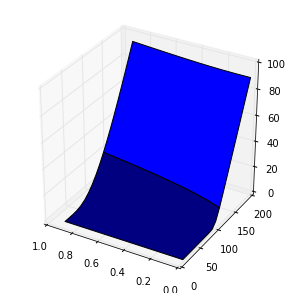

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

K = 100.0
T = 0.50
t = 0.0
r = 0.025
kappa = 2.0
theta = 0.04
sigma = 0.3
rho = -0.5
_lambda = 0.00

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
v = np.arange(0, 1.0, 0.1)
s = np.arange(10, 200, 10)
V, S = np.meshgrid(v, s)

z = np.array([Heston_ExactSolution(K, s, v, T, t, r, kappa, theta, sigma, rho, _lambda) for v, s in zip(np.ravel(V), np.ravel(S))])
Z = z.reshape(V.shape)

ax.plot_surface(V, S, Z)
ax.set_zlim(0, 100)
ax.set_xlim(1.0, 0.0)
ax.set_ylim(0, 200)
plt.show()


In [5]:
K = 100.0
S = 200.0
V = 1.0
T = 1.0
t = 0.0
r = 0.03
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = 0.8
_lambda = 0.0
print Heston_ExactSolution(K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)

110.666917766


# Monte Carlo Simulation for Heston Model

In [6]:
import numpy.random as rnd
def Heston_MonteCarlo(M, K, S0, V0, T, t, r, kappa, theta, sigma, rho, _lambda):
    N = int(numpy.round(252 * (T - t))) + 1
    dt = (T - t) / float(N)
    Sqrtdt = numpy.sqrt(dt)
    
    _k = kappa + _lambda
    _theta = (kappa * theta) / (kappa + _lambda)
    S = numpy.zeros((M, N + 1))
    S[:,0] = S[:,0] + S0
    V = numpy.zeros((M, N + 1))
    V[:,0] = V[:,0] + V0
    Call_vals = numpy.empty(M)
    for i in xrange(M):
        for j in xrange(N):
            dB = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            dW = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
            S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dB
            dZ = rho * dB + numpy.sqrt(1.0 - rho**2) * dW
            V[i,j+1] = V[i,j] + _k * (_theta - V[i,j]) * dt + sigma * numpy.sqrt(abs(V[i,j])) * dZ

        Call_vals[i] = max(S[i,-1] - K, 0.0) * numpy.exp(- r * (T - t))
            
    Call = numpy.mean(Call_vals)
    return Call

In [11]:
M = 10000
K = 100.0
S = 100.0
V = 0.05
T = 1.0
t = 0.0
r = 0.03
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = -0.5
_lambda = 0.05
MC = Heston_MonteCarlo(M, K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)
true = Heston_ExactSolution(K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda) 
print MC
print true

15.7569267088
15.6322471502


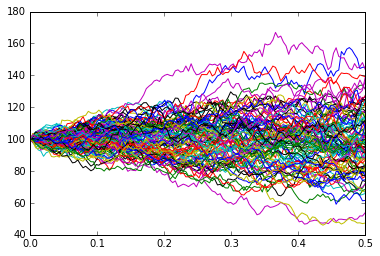

In [10]:
M = 100
K = 100.0
S0 = 100.0
V0 = 0.04
T = 0.5
t = 0.0
r = 0.05
kappa = 2.0
theta = 0.20
sigma = 0.3
rho = -0.5
_lambda = 0.05

N = int(numpy.round(252 * (T - t))) + 1
dt = (T - t) / float(N)
Sqrtdt = numpy.sqrt(dt)
_k = kappa + _lambda
_theta = (kappa * theta) / (kappa + _lambda)
S = numpy.zeros((M, N + 1))
S[:,0] = S[:,0] + S0
V = numpy.zeros((M, N + 1))
V[:,0] = V[:,0] + V0
Call_vals = numpy.empty(M)
for i in xrange(M):
    for j in xrange(N):
        dB = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        dW = Sqrtdt * rnd.normal(0.0,1.0,1)[0]
        S[i,j+1] = S[i,j] + r * S[i,j] * dt + numpy.sqrt(abs(V[i,j])) * S[i,j] * dB
        dZ = rho * dB + numpy.sqrt(1.0 - rho**2) * dW
        V[i,j+1] = V[i,j] + _k*(_theta - V[i,j])*dt + sigma*numpy.sqrt(abs(V[i,j])) * dZ

x = numpy.linspace(t, T, N+1)
for i in xrange(M):
    plt.plot(x, S[i,:])
plt.show()